# Notebook con resultados

## Imports

In [1]:
from sklearn.model_selection import StratifiedKFold
from junifer.storage import HDF5FeatureStorage
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nilearn import plotting

In [2]:
from julearn import run_cross_validation
from julearn import PipelineCreator
from julearn.utils import configure_logging
from sklearn.model_selection import StratifiedKFold
from julearn.viz import plot_scores
from junifer.storage import HDF5FeatureStorage
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA

## Creación de DataFrames

In [3]:
storage = HDF5FeatureStorage("./test.hdf5")
df_fc = storage.read_df('BOLD_parccortical-TianxS3x3TxMNI6thgeneration')
df_alff = storage.read_df('BOLD_ALFF_parccortical-TianxS3x3TxMNI6thgeneration')
df_participants = pd.read_csv("./participants.tsv", sep="\t")
df_participants.rename(columns={"participant_id": "subject"}, inplace=True)
df_participants.set_index("subject", inplace=True)
parcellation_labels = df_alff.columns.values

In [4]:
df_alff_full = df_alff.merge(df_participants, on="subject")
df_fc_full = df_fc.merge(df_participants, on="subject")

In [5]:
es_control = lambda x: 0 if x =="CONTROL" else 1
df_fc_full["is_control"] = df_fc_full["diagnosis"].apply(es_control)
df_alff_full["is_control"] = df_alff_full["diagnosis"].apply(es_control)

## Conectividad funcional promedio por cada grupo de sujetos

<Figure size 1000x800 with 0 Axes>

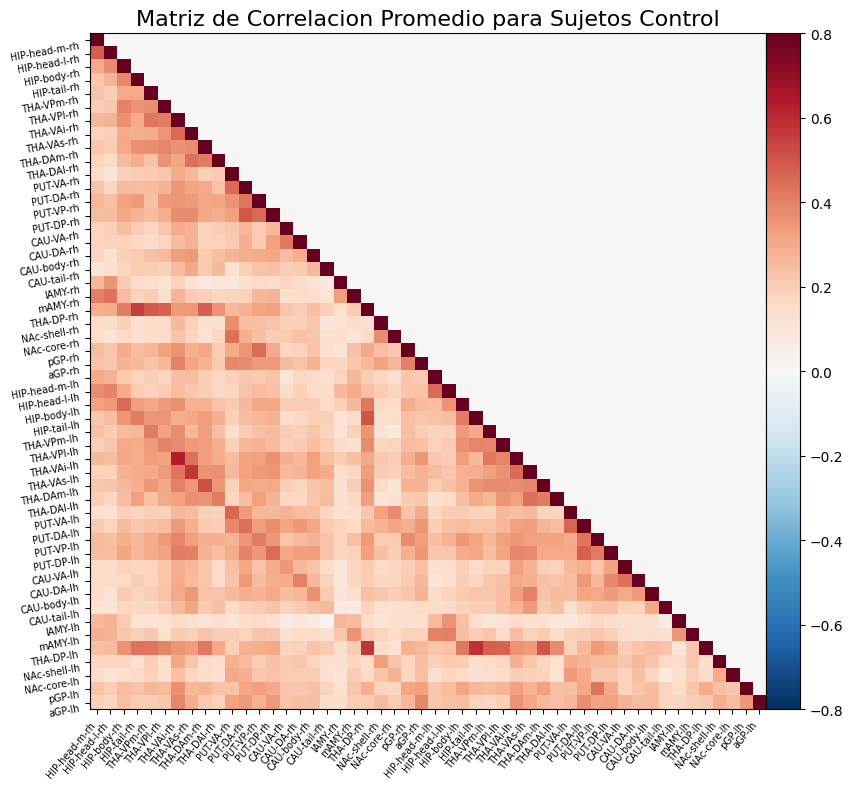

<Figure size 1000x800 with 0 Axes>

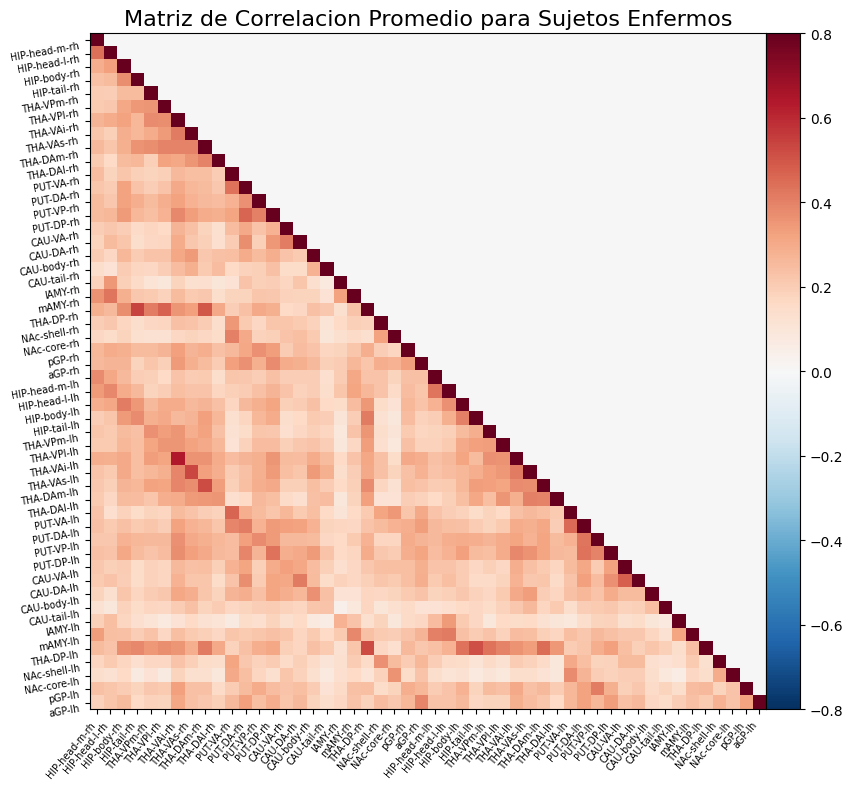

In [6]:
def plot_correlation_matrix(lower_tri_array, parcellation, title="Matriz de Correlacion"):
    n = int((np.sqrt(1 + 8 * len(lower_tri_array)) - 1) / 2)
    
    corr_matrix = np.zeros((n, n))
    
    tri_indices = np.tril_indices(n)
    corr_matrix[tri_indices] = lower_tri_array

    plt.figure(figsize=(10, 8))
    plotting.plot_matrix(corr_matrix, figure=(10, 8), labels=parcellation, colorbar=True, vmax=0.8, vmin=-0.8, title=title)
    plt.show()

# Get the mean value of the correlation matrix for all subjects with diagnosis AD
lower_mean_control = df_fc_full[df_fc_full['is_control'] == 0][df_fc.columns].mean().values
lower_mean_disease = df_fc_full[df_fc_full['is_control'] == 1][df_fc.columns].mean().values


plot_correlation_matrix(lower_mean_control, parcellation=parcellation_labels, title="Matriz de Correlacion Promedio para Sujetos Control")
plot_correlation_matrix(lower_mean_disease, parcellation=parcellation_labels, title="Matriz de Correlacion Promedio para Sujetos Enfermos")


## Exploración con distintos modelos

In [7]:
def remove_diag(features):
    diag = []
    i = 0
    j = 1

    while i < len(features):
        diag.append(features[i])
        j += 1
        i += j

    for elem in diag:
        features.remove(elem)
    
    return features

In [8]:
# Aplicamos semilla para reproducibilidad
df_fc_dev, df_fc_test = train_test_split(df_fc_full, test_size=0.2, stratify=df_fc_full["is_control"], shuffle=True, random_state = 42)
df_alff_dev, df_alff_test = df_alff_full.loc[df_fc_dev.index], df_alff_full.loc[df_fc_test.index]
target = "is_control"
x_fc_cols, x_alff_cols = remove_diag(list(df_fc.columns)), list(df_alff.columns)

In [9]:
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42)

### SVM:
#### Probamos distintas combinaciones de hiperparámetros para kernel lineal, rbf y sigmoide para Functional Connectivity

In [10]:
def creator(model_name, apply_pca, hyperparams):
    creator_ = PipelineCreator(problem_type="classification")
    creator_.add("zscore")
    if apply_pca:
        creator_.add("pca", n_components=50)
    creator_.add(model_name, **hyperparams)
    return creator_

In [11]:

def nested_cv(col_names, target_name, data, model):
    scores, model_final, inspector = run_cross_validation(
        X=col_names,
        y=target_name,
        data = data,
        model=model,
        cv=cv,
        return_inspector=True,
        return_train_score=True,
        return_estimator="all",
        scoring = "roc_auc"
    )
    return scores, model_final, inspector

In [12]:
explor_hyperparams_df_fc = pd.DataFrame()

In [13]:
creator_svm_rbf = creator("svm", True, {"probability":True, "kernel":"rbf", "gamma":np.logspace(-3,3,5), "C":np.logspace(-3,3,5)})
scores_fc_svm_rbf, model_svm_fc_rbf, inspector_fc_svm_rbf = nested_cv(x_fc_cols, target, df_fc_dev, creator_svm_rbf)
explor_hyperparams_df_fc["svm_rbf"] = scores_fc_svm_rbf["test_score"]

In [14]:
creator_svm_lin = creator("svm", True, {"probability":True,"kernel":"linear", "C":np.logspace(-3,3,5)})
scores_fc_svm_lin, model_svm_fc_lin, inspector_fc_svm_lin = nested_cv(x_fc_cols, target, df_fc_dev, creator_svm_lin)
explor_hyperparams_df_fc["svm_lin"] = scores_fc_svm_lin["test_score"]

In [15]:
creator_svm_sigmoid = creator("svm", True, {"probability":True, "kernel":"sigmoid", "gamma":np.logspace(-3,3,5), "C":np.logspace(-3,3,5)})
scores_fc_svm_sigmoid, model_svm_fc_sigmoid, inspector_fc_svm_sigmoid = nested_cv(x_fc_cols, target, df_fc_dev, creator_svm_sigmoid)
explor_hyperparams_df_fc["svm_sigmoid"] = scores_fc_svm_sigmoid["test_score"]

### Random Forests

In [16]:
creator_rf= creator("rf", True, {"n_estimators":[10,30,70,100,200], "max_depth":[None,5,25,50]})
scores_fc_rf, model_fc_rf, inspector_fc_rf = nested_cv(x_fc_cols, target, df_fc_dev, creator_rf)
explor_hyperparams_df_fc["rf"] = scores_fc_rf["test_score"]

In [17]:
explor_hyperparams_df_fc

,svm_rbf,rf,svm_sigmoid,svm_lin
0,0.588745,0.609307,0.562771,0.299816
1,0.363043,0.448913,0.526087,0.748534
2,0.415217,0.416304,0.406522,0.464497
3,0.565217,0.543478,0.592391,0.449300
4,0.331818,0.356818,0.472727,0.548170


Text(0.5, 1.0, 'Resultados para Nested-CV en FC')

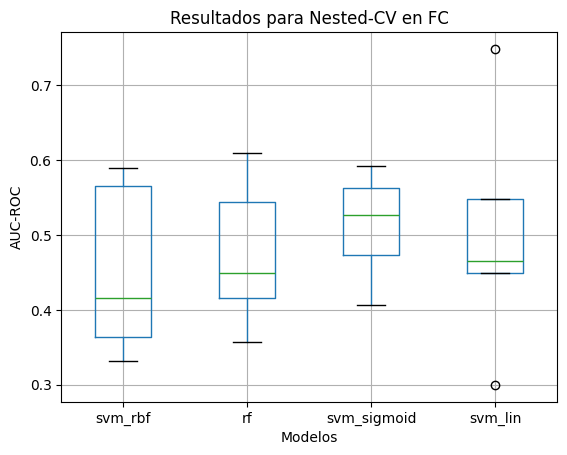

In [19]:
explor_hyperparams_df_fc.boxplot()
plt.xlabel("Modelos")
plt.ylabel("AUC-ROC")
plt.title("Resultados para Nested-CV en FC")

### MODELO FINAL CONECTIVIDAD FUNCIONAL

Elegimos al SVM con kernel Sigmoide como el modelo que utilizaremos

In [21]:
final_model_fc = model_svm_fc_sigmoid.best_estimator_
X_fc_test, y_fc_test = df_fc_test.drop(columns=["is_control"])[x_fc_cols], df_fc_test["is_control"]

In [22]:
model_svm_fc_sigmoid.best_params_

{'svm__C': 1000.0, 'svm__gamma': 31.622776601683793}

In [24]:
preds_fc = final_model_fc.predict_proba(X_fc_test)[:,1]
auc_fc = roc_auc_score(y_fc_test, preds_fc)

In [25]:
f'AUC-ROC = {auc_fc:.3f}'

'AUC-ROC = 0.576'

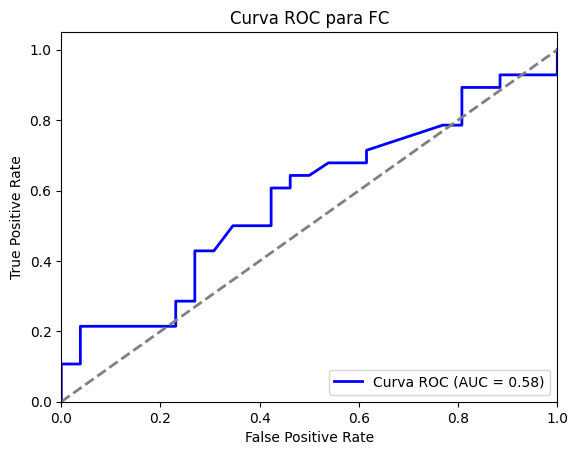

In [27]:
fpr, tpr, _ = roc_curve(y_fc_test, preds_fc)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {auc_fc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC para FC')
plt.legend(loc='lower right')
plt.show()

## Predicción usando ALFF

In [28]:
explor_hyperparams_df_alff = pd.DataFrame()

### Random Forest ALFF

In [29]:
creator_rf= creator("rf", False, {"n_estimators":[10,30,70,100,200], "max_depth":[None,5,25,50]})
scores_alff_rf, model_alff_rf, inspector_alff_rf = nested_cv(x_alff_cols, target, df_alff_dev, creator_rf)
explor_hyperparams_df_alff["rf"] = scores_alff_rf["test_score"]

### SVM (kernels lineal, rbf y sigmoide) ALFF:
#### Probamos distintas combinaciones de hiperparametros para kernel lineal, rbf y sigmoide para los datos de ALFF

In [30]:
creator_svm_lin = creator("svm", False, {"kernel":"linear", "C":np.logspace(-3,3,20)})
scores_alff_svm_lin, model_svm_alff_lin, inspector_alff_svm_lin = nested_cv(x_alff_cols, target, df_alff_dev, creator_svm_lin)
explor_hyperparams_df_alff["svm_lin"] = scores_alff_svm_lin["test_score"]

In [31]:
creator_svm_rbf = creator("svm", False, {"probability":True, "kernel":"rbf", "gamma":np.logspace(-3,3,10), "C":np.logspace(-3,3,10)})
scores_alff_svm_rbf, model_svm_alff_rbf, inspector_alff_svm_rbf = nested_cv(x_alff_cols, target, df_alff_dev, creator_svm_rbf)
explor_hyperparams_df_alff["svm_rbf"] = scores_alff_svm_rbf["test_score"]

In [32]:
creator_svm_sigmoid = creator("svm", False, {"probability":True, "kernel":"sigmoid", "gamma":np.logspace(-3,3,10), "C":np.logspace(-3,3,10)})
scores_alff_svm_sigmoid, model_svm_alff_sigmoid, inspector_alff_svm_sigmoid = nested_cv(x_alff_cols, target, df_alff_dev, creator_svm_sigmoid)
explor_hyperparams_df_alff["svm_sigmoid"] = scores_alff_svm_sigmoid["test_score"]

### MODELO FINAL ALFF

Elegimos al Random Forest como el modelo que utilizaremos

Text(0.5, 1.0, 'Resultados para Nested-CV en ALFF')

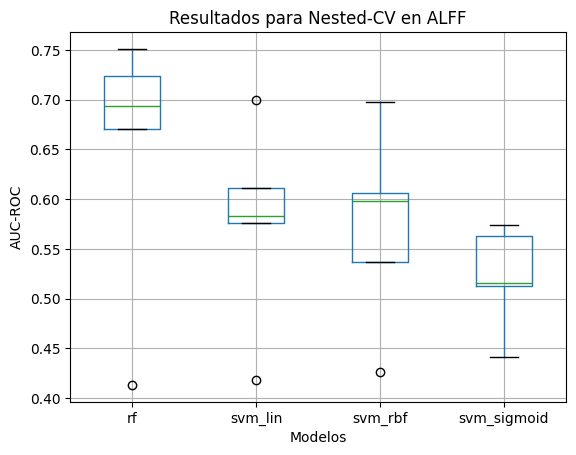

In [33]:
explor_hyperparams_df_alff.boxplot()
plt.xlabel("Modelos")
plt.ylabel("AUC-ROC")
plt.title("Resultados para Nested-CV en ALFF")

In [35]:
modelo_final_alff = model_alff_rf.best_estimator_

In [36]:
X_test_alff, y_test_alff = df_alff_test.drop(columns=["is_control"])[df_alff.columns], df_alff_test["is_control"]

In [37]:
preds_alff = modelo_final_alff.predict_proba(X_test_alff)[:,1]
auc_alff = roc_auc_score(y_test_alff, preds_alff)
f'AUC-ROC = {auc_alff:.3f}'

'AUC-ROC = 0.569'

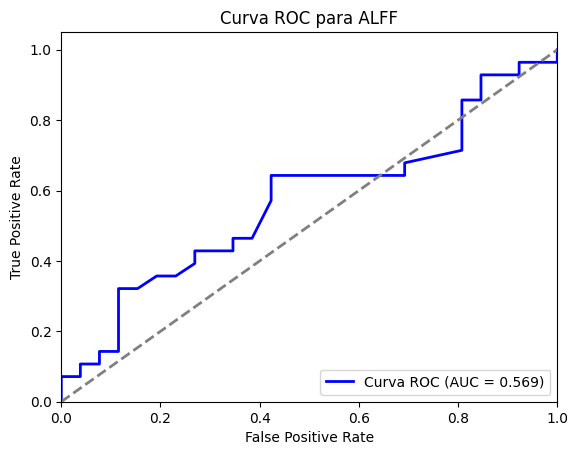

In [39]:
fpr, tpr, _ = roc_curve(y_test_alff, preds_alff)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {auc_alff:.3f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC para ALFF')
plt.legend(loc='lower right')
plt.show()